http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-slope-works.htm
https://www.usna.edu/Users/oceano/pguth/md_help/html/demb1f3n.htm
http://hydrology.usu.edu/taudem/taudem5/help/D8FlowDirections.html

In [1]:
# raster slope calculation
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage
import time
%matplotlib inline

# reproduce the test array in http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-slope-works.htm
ta = np.array([[50.,45.,50.],[30.,30.,30.],[8.,10.,10.]])
print(np.shape(ta))
print(ta)

(3, 3)
[[ 50.  45.  50.]
 [ 30.  30.  30.]
 [  8.  10.  10.]]


In [2]:
# test slope equation results for a 3d array
i=1
j=1
dx = 5;
dy = 5;
dzdx=((ta[i-1,j+1]+2.*ta[i,j+1]+ta[i+1,j+1])-(ta[i-1,j-1]+2.*ta[i,j-1]+ta[i+1,j-1]))/(8.*dx)
dzdy=((ta[i+1,j-1]+2.*ta[i+1,j]+ta[i+1,j+1])-(ta[i-1,j-1]+2.*ta[i-1,j]+ta[i-1,j+1]))/(8.*dy)
# slope in fraction (rise over run)
r = (dzdx**2.+dzdy**2.)**(0.5)
# slope in degrees
d = np.degrees(np.arctan(r))
# azimuth in geographic notation
az=np.degrees( np.arctan2(dzdx,dzdy))
az = (az+360.)%360.
print(dzdx, dzdy)
print("This should be 3.80032893313 75.2576576917 179.246151667: \n",r, d, az)

0.05 -3.8
This should be 3.80032893313 75.2576576917 179.246151667: 
 3.80032893313 75.2576576917 179.246151667


xo,yo:  376191.0 4625539.0
xoff, yoff, xend, yend:  2970 4778 3390 5070


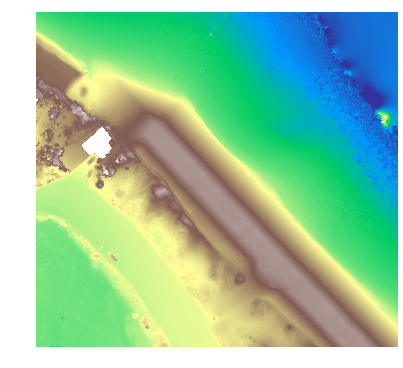

In [3]:
fdir = "D:/2017_Karen_Sandwich_maps/"
fname= "2016-01-22_SandwichTNB_DEM_10cm.tif"

# top left corner of region of interest (UTM Zone 19N meters)
e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows). divide by 10 to get meters
xsize, ysize = 1808, 1680

# declare a plot size
plt.subplots(figsize=(12,6))

with rasterio.open(fdir+fname) as src:
    # location of origin (upper left) from transform
    xo,yo = src.transform*(0,0)
    print('xo,yo: ',xo,yo)
    # index of first col, row in window from inverse transform
    xy = ~src.transform*(e0, n0)
    xoff, yoff = int(xy[0]), int(xy[1])
    print("xoff, yoff, xend, yend: ",xoff, xoff+xsize, yoff, yoff+ysize)
    # load into temporary 2d array
    # note the x,y switch: syntax for window=((row_start, row_stop)(col_start, col_stop)
    z = src.read(1, window=((yoff,yoff+ysize),(xoff,xoff+xsize)))
    src.close()

# small plots of elevation
plt.axis('off');plt.imshow(z,cmap=plt.cm.terrain,vmin=-2,vmax=8)

#plt.savefig('time_series.png')

In [4]:
def slope(z,dx,dy,idegrees=False):
    ny,nx=np.shape(z)
    s = np.nan * np.ones_like(z)
    az = np.nan * np.ones_like(z)
    for i in range(1,ny-1):
        for j in range(1,nx-1):
            dzdx=((z[i-1,j+1]+2.*z[i,j+1]+z[i+1,j+1])-(z[i-1,j-1]+2.*z[i,j-1]+z[i+1,j-1]))/(8.*dx)
            dzdy=((z[i+1,j-1]+2.*z[i+1,j]+z[i+1,j+1])-(z[i-1,j-1]+2.*z[i-1,j]+z[i-1,j+1]))/(8.*dy)
            # slope in fraction (rise over run)
            s[i,j] = (dzdx**2.+dzdy**2.)**(0.5)
            if(idegrees):
               s[i,j] = np.degrees(np.arctan(s[i,j]))
            # azimuth in geographic notation
            az[i,j] =np.degrees( np.arctan2(dzdx,dzdy))
            az[i,j] = (az[i,j]+360.)%360.
    return s, az

start_time = time.time()
s, az = slope(z,.1,.1)
print('Elapsed time: ',time.time()-start_time)

Elapsed time:  62.86699962615967


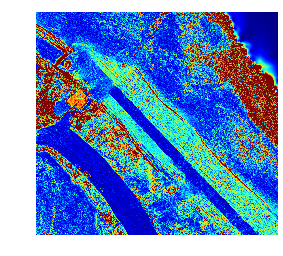

In [5]:
# small plots of elevation
plt.axis('off');plt.imshow(s,cmap=plt.cm.jet,vmin=0.,vmax=.5)

In [6]:
def slope_filter(z,dx,dy,idegrees=False):
    """
    Filter kernal to calculate ArcGIS slope
    Call from scipy.ndimage.filters.generic_filter
        
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        idegrees [optional] - when True, converts returned slope to degrees
        
    Returns:
        s - Raster of slopes in fraction (rise/run)
        
    Use the mode option in generic_filter to treat edges
    Suggest mode='nearest'
        
    See Garrard "Geoprocessing with Python", p. 256.
    """
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # slope in fraction (rise over run)
    s = (dzdx**2.+dzdy**2.)**(0.5)
    if(idegrees):
        s = np.degrees(np.arctan(s))
    return s

def slope_dir_filter(z,dx,dy):
    """
    Filter kernal to calculate ArcGIS slope direction
    Call from scipy.ndimage.filters.generic_filter
    
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        
    Returns:
        az - Raster of slope directions in 0-360
    
    """
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # azimuth in geographic notation
    az=np.degrees( np.arctan2(dzdx,dzdy))
    az = (az+360.)%360.
    return az

def tri_filter(z):
    """
    Filter kernal to calculate ArcGIS topographic roughness index
    Call from scipy.ndimage.filters.generic_filter
    https://gis.stackexchange.com/questions/6056/calculating-topographic-ruggedness-index-in-arcgis-desktop
    
    Iput:
        z - Raster of elevation values
        
    Returns:
        tri - Raster of tri values
    
    """
    tri = np.sqrt(np.sum( z-z[5]**2 ) )
    return tri

start_time = time.time()
sum = scipy.ndimage.filters.generic_filter(z,slope_filter,size=3,mode='nearest',extra_arguments=(.1,.1))
azz = scipy.ndimage.filters.generic_filter(z,slope_dir_filter,size=3,mode='nearest',extra_arguments=(.1,.1))
print('Elapsed time: ',time.time()-start_time)



Elapsed time:  25.281999826431274


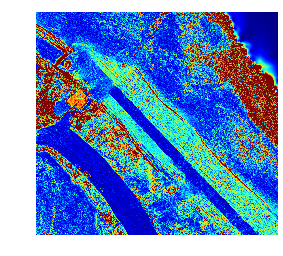

In [8]:
# small plots of elevation
plt.axis('off');plt.imshow(sum,cmap=plt.cm.jet,vmin=0.,vmax=.5)

Calculate the ArgGIS topographic roughness index per
https://gis.stackexchange.com/questions/6056/calculating-topographic-ruggedness-index-in-arcgis-desktop

In [9]:
DEM = np.array([[1,2,3],[4,5,6],[7,8,9]])
DEM=z

start_time = time.time()
s = scipy.ndimage.filters.generic_filter(DEM,np.sum,size=3,mode='constant')
s2 = np.square(DEM)
t = scipy.ndimage.filters.generic_filter(s2,np.sum,size=3,mode='constant')
r = np.sqrt(t + 9.*s2 - 2.*DEM*s)
print('Elapsed time: ',time.time()-start_time)


Elapsed time:  17.58899998664856


C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
start_time = time.time()
tri = scipy.ndimage.filters.generic_filter(z,tri_filter,size=3,mode='nearest')
print('Elapsed time: ',time.time()-start_time)

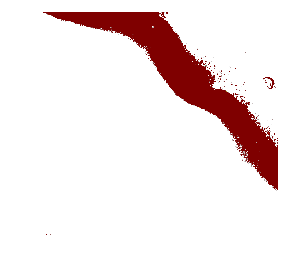

In [11]:
plt.axis('off');plt.imshow(tri,cmap=plt.cm.jet,vmin=0.,vmax=0.05)

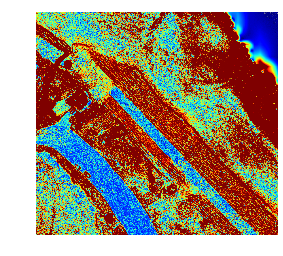

In [12]:
plt.axis('off');plt.imshow(r,cmap=plt.cm.jet,vmin=0.,vmax=0.05)